# Predicting Titanic survival with machine learning 
### Linnéa Good

This script uses a random forest model with SciKit learn to predict the survival of passengers on the Titanic. 

The data consists of a passenger list along with passenger info and is from https://www.kaggle.com/competitions/titanic 

In [17]:
# Random forest model to predict survival on the Titanic 

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn import set_config
import matplotlib.pyplot as plt

There are two datasets to dowload from Kaggle: A training set and a test set. I will train and evaluate the model only on the train dataset, and in the last step I will use the best model I found with the training set to predict whether the passengers in the test set survived or not. I will then submit that result to the Kaggle competition where they will let me know how well my model did. 

In [18]:
# Read data into pandas DataFrame object 
titanic_data = pd.read_csv(
    "C:/Users/Linnea Good/Documents/PhD/Pythonkurs/project/train.csv")

print(titanic_data.head())

# The data I want to predict after I have built the model 
titanic_test_data = pd.read_csv(
    "C:/Users/Linnea Good/Documents/PhD/Pythonkurs/project/test.csv")

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


### Data processing
To start with I removed some columns with variables that I considered to be unhelpful for classification and/or had formats that are too complicated to try and work with: *Name*, *Ticket*, and *Cabin*. 

I also changed the *Sex* column to *Female* and replaced "male" and "female" with 0's and 1's respectively. 

Lastly I created dummy variables for the *Embarked* column as there were 3 possible values there. 

In [19]:
# Set PassengerId as index in DataFrame 
titanic_data = titanic_data.set_index("PassengerId")

titanic_test_data = titanic_test_data.set_index("PassengerId")

# Remove columns that will not help classify (probably) 
titanic_data = titanic_data.drop("Name", axis="columns")
titanic_data = titanic_data.drop("Ticket", axis="columns")
titanic_data = titanic_data.drop("Cabin", axis="columns")

titanic_test_data = titanic_test_data.drop("Name", axis="columns")
titanic_test_data = titanic_test_data.drop("Ticket", axis="columns")
titanic_test_data = titanic_test_data.drop("Cabin", axis="columns")

# Make Female = 1 and Male = 0 
titanic_data['Sex'] = titanic_data['Sex'].map({'male':0,'female':1})
titanic_data = titanic_data.rename(columns={"Sex": "Female"})

titanic_test_data['Sex'] = titanic_test_data['Sex'].map({'male':0,'female':1})
titanic_test_data = titanic_test_data.rename(columns={"Sex": "Female"})

# Create dummy variables for Embarked 
titanic_data = pd.get_dummies(titanic_data)

titanic_test_data = pd.get_dummies(titanic_test_data)

In [20]:
# Split the data into features (X) and target (Y)
X = titanic_data.drop("Survived", axis=1)
Y = titanic_data["Survived"] 

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

The *Age* column contained about 20% missing values, and since the random forest model cannot handle NaNs, I decided to impute the missing values with the mean age of the dataset (about 29 years). 

In [21]:
# Impute age to handle NaNs 
print("Proportion of NaNs in Age column: " + str(titanic_data["Age"].isna().sum() / len(titanic_data["Age"])))

set_config(transform_output="pandas") # To keep imputed output as pandas DF

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)
titanic_test_data = imp.transform(titanic_test_data)

Proportion of NaNs in Age column: 0.19865319865319866


### Hyperparameter tuning 
I used the RandomizedSearchCV to try and search for the optimal parameters to use in the model. 

In [22]:
rf = RandomForestClassifier()

# Hyperparameter tuning 
hyperparameters = {'n_estimators': randint(200,800),
              'max_depth': randint(20,40)}

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = hyperparameters, 
                                 n_iter=10, 
                                 cv=5)

rand_search.fit(X_train_imp, Y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
Y_pred = best_rf.predict(X_test_imp)

Best hyperparameters: {'max_depth': 38, 'n_estimators': 326}


### Evaluating model accuracy
To evaluate the accuracy of my model, I calculate the accuracy, precision, and recall of the model, and plot a confusion matrix. 

Accuracy: 0.8100558659217877
Precision: 0.7692307692307693
Recall: 0.7246376811594203


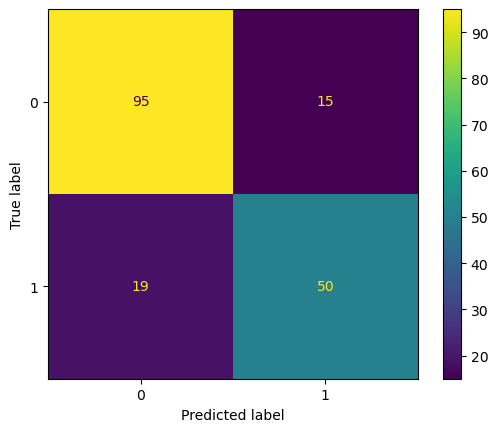

In [23]:
# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

And just because it's interesting, I also plotted the most important features for survival. 

It made me a bit surprised that Fare seems to be so important, but one thing to note is that (from my understanding) when several people traveled together the fare will be combined for all of them. This means that the *Fare* variable is actually basically a combination of the Ticket class (*Pclass*) and number of siblings, spouses (*SibSp*), parents and children (*ParCh*) variables. And maybe even the *Age* and *Female* variables, as children and women were less likely to travel alone, thereby raising the apparent fare for younger people and women. 

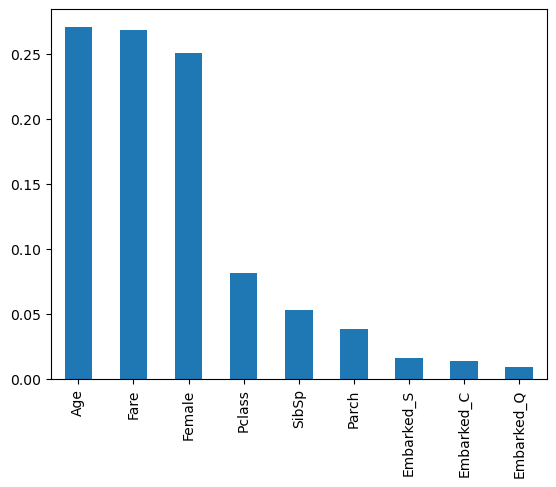

In [24]:
# Create bar plot of most important features in the model 
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns).sort_values(
    ascending=False)

feature_importances.plot.bar();

In [25]:
# And finally: Use the trained model to predict the test data 
# Need to first merge with DataFrame to keep index 
titanic_test_data["Survived"] = best_rf.predict(titanic_test_data) 
Survival_pred = titanic_test_data[["Survived"]]

# Save predictions to submit to Kaggle 
Survival_pred.to_csv("Survival.csv", index=True)

### Submission results 
After submitting my results to Kaggle, I managed to get a precision score of 0.76315, meaning I guessed correctly about 76% of times. This landed me on spot number 12524 on their leaderboard! 